# Uşak Elektrik Arıza Rota Optimizasyonu (ACO) – Colab Çalışması

## Senaryo
Uşak ilinde 15 farklı mahallede aynı anda arıza bildirimi gelmiştir. Tek bir teknik ekip, tüm lokasyonları **minimum toplam mesafe / minimum süre** ile ziyaret ederek müdahale etmelidir.

## Amaç
- Lokasyonlar arası mesafelerden bir **mesafe matrisi** oluşturmak
- Karınca Kolonisi Algoritması (ACO) ile en iyi turu bulmak
- Sonucu:
  - Yakınsama grafiği
  - Harita üzerinde rota çizimi
  ile görselleştirmek



In [13]:
!pip -q install googlemaps folium

import math
import numpy as np
import googlemaps
import matplotlib.pyplot as plt
import folium



In [14]:
from google.colab import userdata

API_KEY = userdata.get("API_KEY")  # Secrets'ta KEY adı: API
if not API_KEY:
    raise ValueError("API bulunamadı. Colab Secrets/userdata içine 'API' adıyla ekle.")

gmaps = googlemaps.Client(key=API_KEY)
print("✅ API key okundu.")



✅ API key okundu.


In [15]:
USAK_LOCATIONS = [
    "Kemalöz Mahallesi, Uşak, Türkiye",
    "Fevzi Çakmak Mahallesi, Uşak, Türkiye",
    "Atatürk Mahallesi, Uşak, Türkiye",
    "Cumhuriyet Mahallesi, Uşak, Türkiye",
    "Işık Mahallesi, Uşak, Türkiye",
    "Kurtuluş Mahallesi, Uşak, Türkiye",
    "Mehmet Akif Ersoy Mahallesi, Uşak, Türkiye",
    "Dikilitaş Mahallesi, Uşak, Türkiye",
    "Bozkurt Mahallesi, Uşak, Türkiye",
    "Fatih Mahallesi, Uşak, Türkiye",
    "Aybey Mahallesi, Uşak, Türkiye",
    "Yeni Mahalle, Uşak, Türkiye",
    "Sarayaltı Mahallesi, Uşak, Türkiye",
    "Yukarıkuyucak Mahallesi, Uşak, Türkiye",
    "Eşme yolu civarı, Uşak, Türkiye",
]

n = len(USAK_LOCATIONS)
print("Lokasyon sayısı:", n)


Lokasyon sayısı: 15


In [16]:
def geocode_locations(locations):
    coords = []
    for loc in locations:
        res = gmaps.geocode(loc)
        if not res:
            raise ValueError(f"Adres bulunamadı: {loc}")
        pos = res[0]["geometry"]["location"]
        coords.append((loc, float(pos["lat"]), float(pos["lng"])))
    return coords

coords = geocode_locations(USAK_LOCATIONS)
coords[:2]



[('Kemalöz Mahallesi, Uşak, Türkiye', 38.6700047, 29.3743939),
 ('Fevzi Çakmak Mahallesi, Uşak, Türkiye', 38.6684427, 29.4324423)]

In [17]:
def build_driving_matrix_blocked(locations, block=10, mode="driving"):
    n = len(locations)
    m = np.zeros((n, n), dtype=float)

    for i0 in range(0, n, block):
        origins = locations[i0:i0+block]

        for j0 in range(0, n, block):
            dests = locations[j0:j0+block]

            resp = gmaps.distance_matrix(
                origins=origins,
                destinations=dests,
                mode=mode,
                units="metric",
                language="tr",
            )

            if resp.get("status") != "OK":
                raise RuntimeError(
                    f"Distance Matrix status={resp.get('status')} "
                    f"err={resp.get('error_message','')}"
                )

            rows = resp.get("rows", [])
            for oi, row in enumerate(rows):
                elements = row.get("elements", [])
                for dj, el in enumerate(elements):
                    ii = i0 + oi
                    jj = j0 + dj

                    if ii == jj:
                        m[ii, jj] = 0.0
                        continue

                    if el.get("status") == "OK":
                        m[ii, jj] = el["distance"]["value"] / 1000.0
                    else:
                        m[ii, jj] = 1e6  # ceza

    return m

dist = build_driving_matrix_blocked(USAK_LOCATIONS, block=10, mode="driving")
dist[:3, :3]


array([[0.   , 6.307, 6.371],
       [6.664, 0.   , 3.005],
       [6.542, 1.74 , 0.   ]])

In [18]:
def route_length(route, dist):
    total = 0.0
    for i in range(len(route) - 1):
        total += dist[route[i], route[i+1]]
    total += dist[route[-1], route[0]]
    return float(total)

def run_aco(
    distance_matrix,
    ant_count=50,
    n_iterations=150,
    alpha=1.0,
    beta=3.0,
    rho=0.4,
    q=100.0,
    seed=7
):
    dist = np.asarray(distance_matrix, dtype=float)
    n = dist.shape[0]

    heuristic = np.zeros_like(dist)
    with np.errstate(divide="ignore", invalid="ignore"):
        inv = 1.0 / dist
    inv[~np.isfinite(inv)] = 0.0
    inv[dist <= 0] = 0.0
    heuristic = inv

    pheromone = np.ones((n, n), dtype=float)

    best_path = None
    best_length = float("inf")
    history = []

    rng = np.random.default_rng(seed)
    nodes = np.arange(n)

    for _it in range(n_iterations):
        routes = []
        lengths = []

        for _k in range(ant_count):
            start = int(rng.integers(0, n))
            route = np.empty(n, dtype=int)
            route[0] = start

            visited = np.zeros(n, dtype=bool)
            visited[start] = True
            current = start

            for step in range(1, n):
                candidates = nodes[~visited]
                tau = pheromone[current, candidates] ** alpha
                eta = heuristic[current, candidates] ** beta
                probs = tau * eta
                s = probs.sum()

                if s <= 0 or not np.isfinite(s):
                    nxt = int(rng.choice(candidates))
                else:
                    probs = probs / s
                    nxt = int(rng.choice(candidates, p=probs))

                route[step] = nxt
                visited[nxt] = True
                current = nxt

            L = route_length(route, dist)
            routes.append(route)
            lengths.append(L)

            if L < best_length:
                best_length = L
                best_path = route.copy()

        history.append(float(best_length))

        pheromone *= (1.0 - rho)

        for route, L in zip(routes, lengths):
            deposit = q / (L + 1e-9)
            for i in range(n - 1):
                a, b = route[i], route[i+1]
                pheromone[a, b] += deposit
                pheromone[b, a] += deposit
            a, b = route[-1], route[0]
            pheromone[a, b] += deposit
            pheromone[b, a] += deposit

    return best_path.tolist(), float(best_length), history

best_path, best_len, history = run_aco(dist)
print("✅ En iyi toplam driving mesafe:", round(best_len, 2), "km")
print("✅ Rota indeksleri:", best_path)


✅ En iyi toplam driving mesafe: 265.01 km
✅ Rota indeksleri: [0, 7, 8, 4, 10, 5, 13, 3, 9, 2, 1, 12, 6, 11, 14]


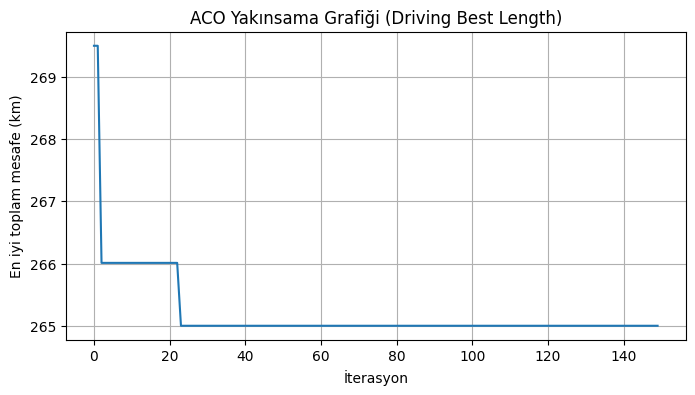

In [19]:
plt.figure(figsize=(8,4))
plt.plot(history)
plt.title("ACO Yakınsama Grafiği (Driving Best Length)")
plt.xlabel("İterasyon")
plt.ylabel("En iyi toplam mesafe (km)")
plt.grid(True)
plt.show()



In [20]:
center_lat = np.mean([c[1] for c in coords])
center_lng = np.mean([c[2] for c in coords])
m = folium.Map(location=[center_lat, center_lng], zoom_start=12)

# Markerlar
for idx, (name, lat, lng) in enumerate(coords):
    folium.Marker(
        location=[lat, lng],
        popup=f"{idx} - {name}",
        tooltip=str(idx)
    ).add_to(m)

# Rota çizgisi (tur kapalı)
route_points = [(coords[i][1], coords[i][2]) for i in best_path]
route_points.append(route_points[0])

folium.PolyLine(route_points, weight=5).add_to(m)

m


## Sonuç ve Değerlendirme

Bu çalışmada, Uşak ilinde aynı anda arıza bildirimi alınan **15 farklı lokasyon** için tek bir teknik ekibin izlemesi gereken en uygun rota, **Karınca Kolonisi Algoritması (Ant Colony Optimization – ACO)** kullanılarak hesaplanmıştır.

### Kullanılan Yöntemler ve Parametreler
- **Mesafe Türü:**  
  Google Distance Matrix API kullanılarak **gerçek yol mesafesi (driving distance)** hesaplanmıştır.  
  API limitlerini aşmamak için mesafe matrisi **blok blok (10×10)** olacak şekilde oluşturulmuştur.
- **Optimizasyon Algoritması:** Karınca Kolonisi Algoritması (ACO)
- **ACO Parametreleri:**
  - Karınca sayısı: 50  
  - İterasyon sayısı: 150  
  - Alpha (feromon etkisi): 1.0  
  - Beta (sezgisel bilgi etkisi): 3.0  
  - Rho (buharlaşma oranı): 0.4  
  - Q (feromon miktarı): 100  

### Elde Edilen Sonuçlar
- Algoritma, iterasyonlar ilerledikçe **toplam rota mesafesini kademeli olarak düşürmüş** ve yakınsamaya ulaşmıştır.
- Yakınsama grafiği, ACO’nun zamanla daha iyi çözümler ürettiğini ve belirli bir iterasyondan sonra **en iyi çözüm etrafında kararlı hale geldiğini** göstermektedir.
- En iyi bulunan çözümde, teknik ekip tüm lokasyonları **tek bir tur içinde** ziyaret etmekte ve başlangıç noktasına geri dönmektedir.
- Harita üzerinde çizilen rota, gerçek yol ağları dikkate alınarak elde edilen **en uygun ziyaret sırasını** görsel olarak sunmaktadır.

### Değerlendirme
Elde edilen sonuçlar, Karınca Kolonisi Algoritması’nın **gezgin satıcı problemi (TSP)** benzeri gerçek dünya senaryolarında etkili bir şekilde kullanılabildiğini göstermektedir.  
Özellikle elektrik arıza müdahalesi gibi zaman ve maliyetin kritik olduğu durumlarda, bu yaklaşım sayesinde:
- Müdahale süresi kısaltılabilir,
- Yakıt ve operasyon maliyetleri azaltılabilir,
- Teknik ekip verimliliği artırılabilir.

Bu çalışma, sezgisel optimizasyon algoritmalarının **akıllı şehirler ve altyapı yönetimi** problemlerinde uygulanabilirliğini ortaya koymaktadır.
